In [1]:
"""modelos_config = [
    {"hidden_sizes": [32], "dropout": 0.0, "lr": 0.0025},
    {"hidden_sizes": [32, 16], "dropout": 0.25, "lr": 0.0025},
    {"hidden_sizes": [64, 32, 16], "dropout": 0.25, "lr": 0.0025},
    {"hidden_sizes": [16, 32, 16], "dropout": 0.25, "lr": 0.0025},
]"""

'modelos_config = [\n    {"hidden_sizes": [32], "dropout": 0.0, "lr": 0.0025},\n    {"hidden_sizes": [32, 16], "dropout": 0.25, "lr": 0.0025},\n    {"hidden_sizes": [64, 32, 16], "dropout": 0.25, "lr": 0.0025},\n    {"hidden_sizes": [16, 32, 16], "dropout": 0.25, "lr": 0.0025},\n]'

In [2]:
from src.TimeSeries import TimeSeries
from src.TimeSeriesPlot import TimeSeriesPlot
import yfinance as yf
from src.LSTMsPrediction import LSTMForecaster

# Descargar cotizaciones de MELI (Mercado Libre)
meli = yf.download('MELI', start='2022-01-01', interval='1d')
dates = meli.index
meli_prices = meli['Close']['MELI']

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [3]:
# Serie completa
ts_full = TimeSeries("$MELI original", dates, meli_prices)

# Serie recortada
index_until_2025 = len(dates[dates.year < 2025])
dates_until_2025 = dates[:index_until_2025]
ts_until_2025 = TimeSeries("$MELI original", dates_until_2025, meli_prices[:index_until_2025])

In [49]:
# Inicializar forecaster sobre recortada
forecaster = LSTMForecaster(ts_until_2025, look_back=10, test_size=0.1, batch_size=8)

# Inicializar modelo y entrenarlo
forecaster.init_model(input_size=1, hidden_sizes=[64, 32], output_size=1, dropout=0.3)
forecaster.train(epochs=100, lr=0.002)

# Evaluar autoregresivamente con datos reales
predictions, actuals = forecaster.evaluate()

/home/neville/GitHub/time-series-analysis/.venv/lib/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Epoch 10/100 - Loss: 0.022993
Epoch 20/100 - Loss: 0.006837
Epoch 30/100 - Loss: 0.004738
Epoch 40/100 - Loss: 0.005070
Epoch 50/100 - Loss: 0.005113
Epoch 60/100 - Loss: 0.005457
Epoch 70/100 - Loss: 0.004669
Epoch 80/100 - Loss: 0.003276
Epoch 90/100 - Loss: 0.003818
Epoch 100/100 - Loss: 0.003369
Test MSE: 3891.2469, Test MAE: 41.0073


In [50]:
dates_until_test = dates_until_2025[int(len(dates_until_2025)*0.9):]
ts_pred = TimeSeries("Predicción test (autoregresiva CON datos reales)", dates_until_test, predictions)

In [51]:
future_predictions = forecaster.forecast_future(steps=50)
dates_after_2025 = dates[index_until_2025:index_until_2025+50]

ts_future = TimeSeries("Predicción futura (autoregresiva SIN datos reales)", dates_after_2025, future_predictions)

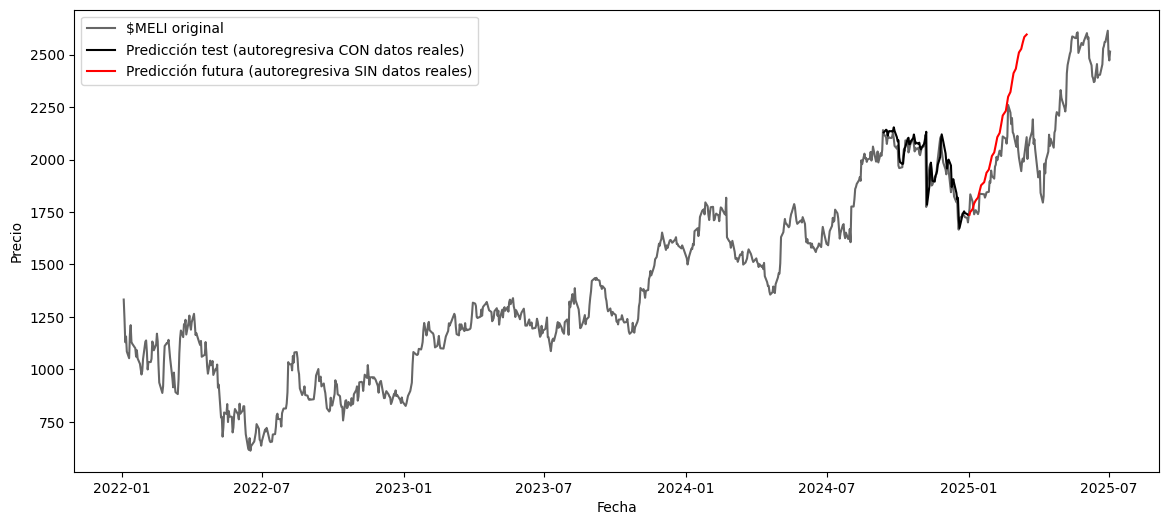

In [52]:
plot = TimeSeriesPlot(ts_full)
plot.add_original(alpha=0.6, color='black')
plot.add_another(ts_pred, color='black')
plot.add_another(ts_future, color="red")
plot.show()